In [1]:
from functions import fcs as fcs
import numpy as np
from firedrake import * 
from problem import PROBLEM
from SDC_CLASS_UFL import SOLVER

#################################################################
################## Setting up the problem #######################
#################################################################

a = 0                           # time of start
b = 3                           # time of end
n = 512                         # number of spatial nodes
n_steps = 154.                  # number of time steps
dt = (b-a)/(n_steps)            # delta t


# mesh for firedrake
mesh = PeriodicIntervalMesh(n, 1)   # create periodic grid
x = SpatialCoordinate(mesh)[0]      # extract coordinates


# Function Space for firedrake
VV = FunctionSpace(mesh, 'Lagrange', 1)  # function space. Functions will be approximated using first order Lagrange Polynomials
V2 = FunctionSpace(mesh, 'CG', 1)
V = VV*V2                                # Create mixed functions space. Need to use due to coupled system

#################################################################
#################### SDC related parameters #####################
#################################################################

M = 1                               # number of GL nodes used for quadrature
SDC_iterations= 0
SDC_nodes = M


#################################################################
################### Setup initial conditions ####################
#################################################################

x1 = 0.25
x0 = 0.75
sigma = 0.1
k = 7.2*np.pi


def p0(x, sigma=sigma):
    return exp(-x**2/sigma**2)
                 
def p1(x, p0=p0, sigma=sigma, k=k):
    return p0(x)*cos(k*x/sigma)

def p(x, p0=p0, p1=p1, x0=x0, x1=x1, coeff=1.):
    return p0(x-x0) + coeff*p1(x-x1)

p_init = p(x)   
U_n = Function(V)                        # Vector containing Solutions at t
u_n, p_n = U_n.split()
p_n.interpolate(p_init)

#################################################################
################ Setup RHS of acoustic advection ################
#################################################################
# problem specific constants
c_s = Constant(1)                   # speed of sound
U = Constant(0.05)                  # mean flow

def ff1(p_n, c_s):
    return -c_s*p_n.dx(0)

def ff2(u_n, c_s):
    return -c_s*u_n.dx(0)

def fs1(u_n, U):
    return -U*u_n.dx(0)

def fs2(p_n, U):
    return -U*p_n.dx(0)

In [2]:
# solving

p = PROBLEM(U_n, ff1, ff2, fs1, fs2 , V, c_s, U)
solver = SOLVER(p)        #check CFL

solver.setup(np.linspace(a,b,int(n_steps+1)),SDC_nodes = SDC_nodes, SDC_iterations = SDC_iterations, isnonlinear=False, delta_x = (b-a)/n)
# solve until t_final is reached
solver.solve()

/prog/firedrake/lib64/python3.6/site-packages/numpy/lib/polynomial.py:1273: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)
/prog/firedrake/lib64/python3.6/site-packages/numpy/lib/polynomial.py:1273: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)
/prog/firedrake/lib64/python3.6/site-packages/numpy/lib/polynomial.py:1273: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)
/prog/firedrake/lib64/python3.6/site-packages/numpy/lib/polynomial.py:1273: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)
/prog/firedrake/lib64/python3.6/site-packages/numpy/lib/polynomial.py:1273: FutureWarning: In the future extra properties will not be copied acr

/prog/firedrake/src/firedrake/firedrake/plot.py:808: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  patch = matplotlib.patches.PathPatch(path, **kwargs)


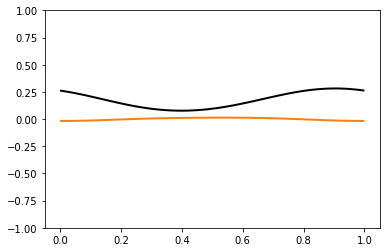

In [3]:
# NBVAL_IGNORE_OUTPUT
import matplotlib.pyplot as plt
fig, axes = plt.subplots()
#axes.set_ylim((-1., 1.))
from matplotlib.animation import FuncAnimation
#tt = np.arange(0,t_end+d_t,d_t)
results = solver.solution
def animate(U_n):
    u_n, p_n = U_n.split()
    axes.clear()
    firedrake.plot(u_n, axes=axes,color='C1')
    firedrake.plot(p_n, axes=axes)
    axes.set_ylim((-1., 1.))
    #axes.annotate('t: %.2f' % t,xy=(0.1,0.1))

interval = 5e3 * float(dt)
animation = FuncAnimation(fig, animate, frames=results, interval=interval)

from IPython.display import HTML
HTML(animation.to_jshtml())